In [21]:
import numpy as np
import matplotlib.pyplot as plt

In [22]:
def diffuse_agents(x, y, d, L):
    """
    Moves agents on the lattice based on diffusion probability.

    Parameters
    ----------
    x, y : Agents' positions.
    d : Diffusion probability.
    L : Side length of the lattice.

    Returns
    -------
    x, y : Updated positions.
    """
    N = np.size(x)
    diffuse = np.random.rand(N)
    move = np.random.randint(4, size=N)
    for i in range(N):
        if diffuse[i] < d:
            if move[i] == 0:
                x[i] = x[i] - 1
            elif move[i] == 1:
                y[i] = y[i] - 1
            elif move[i] == 2:
                x[i] = x[i] + 1
            else:
                y[i] = y[i] + 1

    # Enforce periodic boundary conditions.
    x = x % L
    y = y % L

    return x, y

In [23]:
def update_opinions(x, y, opinions, influencer_flags, media_flags, age_groups, mu, attraction, deattraction, L, influence_radius, media_radius):
    """
    Updates agents' opinions based on interactions.

    Parameters
    ----------
    x, y : Agents' positions.
    opinions : Agents' opinions.
    influencer_flags : Boolean array indicating influencer agents.
    mu : Convergence parameter.
    attraction : Confidence bound.
    L : Side length of the lattice.
    influence_radius : Radius of influence for influencer agents.

    Returns
    -------
    opinions : Updated opinions.
    """
    N = np.size(x)
    # Create a grid to map agents to their positions for efficient lookup
    position_dict = {}
    for i in range(N):
        pos = (x[i], y[i])
        if pos in position_dict:
            position_dict[pos].append(i)
        else:
            position_dict[pos] = [i]
            
    # Define influence probabilities for each age group
    # Index 0 for young, 1 for old
    p_influencer = np.array([0.75, 0.10])  # 75% for young, 10% for old
    p_nearby = np.array([0.25, 0.75])      # 25% for young, 75% for old
    p_media = np.array([0.50, 0.50])       # 50 % for young, 50% for old

    # Interaction step
    for i in range(N):
        # Skip if influencer agent (they don't change their opinions)
        if influencer_flags[i]:
            continue

        # Agents in the same cell
        same_cell_agents = position_dict[(x[i], y[i])]
        for j in same_cell_agents:
            if i != j:
                # Determine if agent i will be influenced by nearby agents
                if np.random.rand() < p_nearby[age_groups[i]]:
                    if abs(opinions[i] - opinions[j]) < attraction:
                        # Update opinions towards each other
                        o_i = opinions[i]
                        o_j = opinions[j]
                        opinions[i] = o_i + mu * (o_j - o_i)
                    elif abs(opinions[i] - opinions[j]) > deattraction:
                        # Update opinions away from each other
                        o_i = opinions[i]
                        o_j = opinions[j]
                        opinions[i] = o_i - mu * (o_j - o_i)
                    opinions[i] = np.clip(opinions[i], 0, 1)

        # Influencer agents within influence radius
        for j in np.where(influencer_flags)[0]:
            # Calculate distance between agents considering periodic boundaries
            dx = min(abs(x[i] - x[j]), L - abs(x[i] - x[j]))
            dy = min(abs(y[i] - y[j]), L - abs(y[i] - y[j]))
            distance = np.sqrt(dx**2 + dy**2)

            if distance <= influence_radius:
                # Determine if agent i will be influenced by influencers
                if np.random.rand() < p_influencer[age_groups[i]]:
                    if abs(opinions[i] - opinions[j]) < attraction:
                        # Update opinion towards the influencer
                        o_i = opinions[i]
                        o_j = opinions[j]
                        opinions[i] = o_i + mu * (o_j - o_i)
                    elif abs(opinions[i] - opinions[j]) > deattraction:
                        # Update opinion away from the influencer
                        o_i = opinions[i]
                        o_j = opinions[j]
                        opinions[i] = o_i - mu * (o_j - o_i)
                    opinions[i] = np.clip(opinions[i], 0, 1)
        # Media agents within media radius
        for j in np.where(media_flags)[0]:
            # Calculate distance between agents considering periodic boundaries
            dx = min(abs(x[i] - x[j]), L - abs(x[i] - x[j]))
            dy = min(abs(y[i] - y[j]), L - abs(y[i] - y[j]))
            distance = np.sqrt(dx**2 + dy**2)

            if distance <= media_radius:
                # Determine if agent i will be influenced by media
                if np.random.rand() < p_media[age_groups[i]]:
                    if abs(opinions[i] - opinions[j]) < attraction:
                        # Update opinion towards the media
                        o_i = opinions[i]
                        o_j = opinions[j]
                        opinions[i] = o_i + mu * (o_j - o_i)
                    elif abs(opinions[i] - opinions[j]) > deattraction:
                        # Update opinion away from the media
                        o_i = opinions[i]
                        o_j = opinions[j]
                        opinions[i] = o_i - mu * (o_j - o_i)
                    opinions[i] = np.clip(opinions[i], 0, 1)
        
    return opinions

In [24]:
def run_opinion_simulation(N_part, N_influencers, N_media, L, d, mu, attraction, deattraction, influence_radius, media_radius, max_steps):
    # Initialize agents' positions
    x = np.random.randint(L, size=N_part)
    y = np.random.randint(L, size=N_part)

    opinions = np.random.normal(0.5, 0.2, N_part)
    opinions = np.clip(opinions, 0, 1)

    # Assign age groups
    age_proportions = [0.5, 0.5]  # 0.75 young, 0.25 old
    age_groups = np.random.choice([0, 1], size=N_part, p=age_proportions)

    # Generate a random permutation of indices
    indices = np.random.permutation(N_part)

    # Assign first N_influencers as influencers
    influencer_flags = np.zeros(N_part, dtype=bool)
    influencer_flags[indices[:N_influencers]] = True

    # Assign the next N_media as media agents
    media_flags = np.zeros(N_part, dtype=bool)
    media_flags[indices[N_influencers:N_influencers + N_media]] = True

    # Set media agents' opinions (e.g., neutral opinions)
    opinions[media_flags] = 0.1  # Media agents hold opinion 0.1

    # Set influencer agents' opinions (e.g., extreme opinions)
    opinions[influencer_flags] = 0.9  # Influencers hold opinion 0.9

    opinions_over_time = []
    for step in range(max_steps):
        # Diffusion step
        x, y = diffuse_agents(x, y, d, L)

        # Update opinions
        opinions = update_opinions(
            x, y, opinions, influencer_flags, media_flags, age_groups,
            mu, attraction, deattraction, L, influence_radius, media_radius
        )

        opinions_over_time.append(opinions.copy())

    return opinions_over_time, influencer_flags, age_groups


In [25]:
def simulate_and_plot(N_part, N_influencers, N_media, L, d, mu, attraction, deattraction, influence_radius, media_radius, max_steps, num_runs, title):
    """
    Runs multiple simulations and plots the results.

    Parameters
    ----------
    N_part : Total number of agents (including influencers).
    N_influencers : Number of influencer agents.
    N_media : Number of media agents.
    L : Side length of the lattice.
    d : Diffusion probability.
    mu : Convergence parameter.
    attraction : Confidence bound.
    deattraction : Deattraction bound.
    influence_radius : Radius of influence for influencer agents.
    media_radius : Radius of influence for media agents.
    max_steps : Maximum number of time steps.
    num_runs : Number of independent runs.
    title : Title for the plots.
    """
    for run in range(num_runs):
        opinions_over_time, influencer_flags, age_groups  = run_opinion_simulation(
            N_part, N_influencers, N_media, L, d, mu, attraction, deattraction, influence_radius, media_radius, max_steps
        )

        # Plotting the opinion distributions at different time steps
        time_steps = [0, int(len(opinions_over_time) / 4), int(len(opinions_over_time) / 2), len(opinions_over_time) - 1]
        for t in time_steps:
            plt.figure(figsize=(10, 6))
            # Plot for young agents
            plt.hist(
                [opinions_over_time[t][(age_groups == 0) & (~influencer_flags)]],
                bins=20,
                alpha=0.5,
                label=f'Young Agents at Time {t}'
            )
            # Plot for old agents
            plt.hist(
                [opinions_over_time[t][(age_groups == 1) & (~influencer_flags)]],
                bins=20,
                alpha=0.5,
                label=f'Old Agents at Time {t}'
            )
            plt.xlabel('Opinion')
            plt.ylabel('Number of agents')
            plt.title(f'Run {run + 1}: {title}')
            plt.legend()
            plt.show()


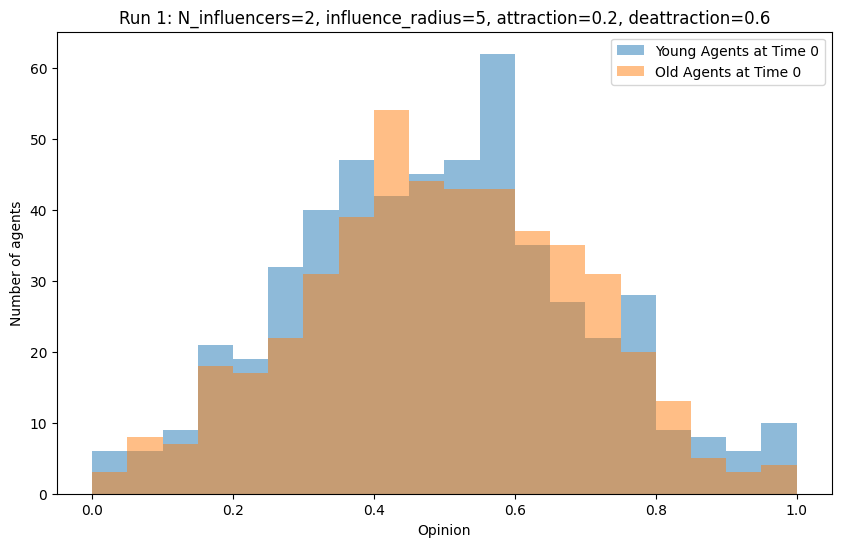

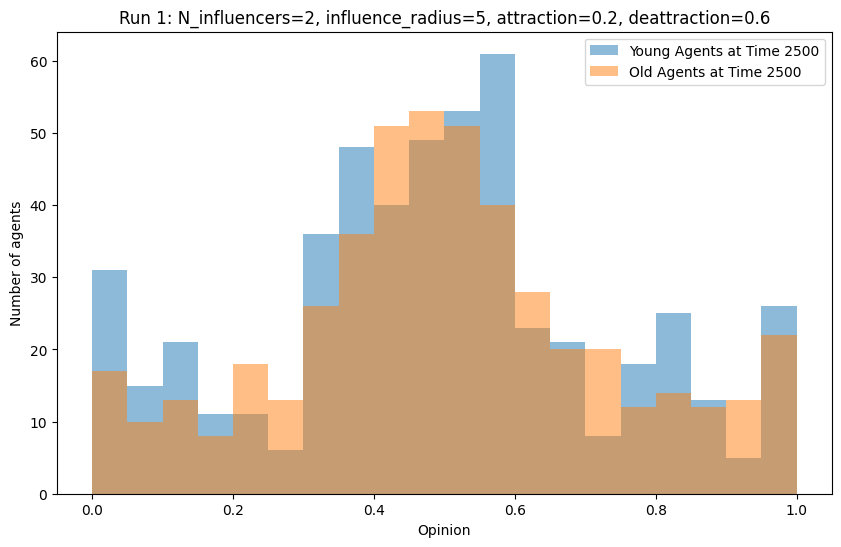

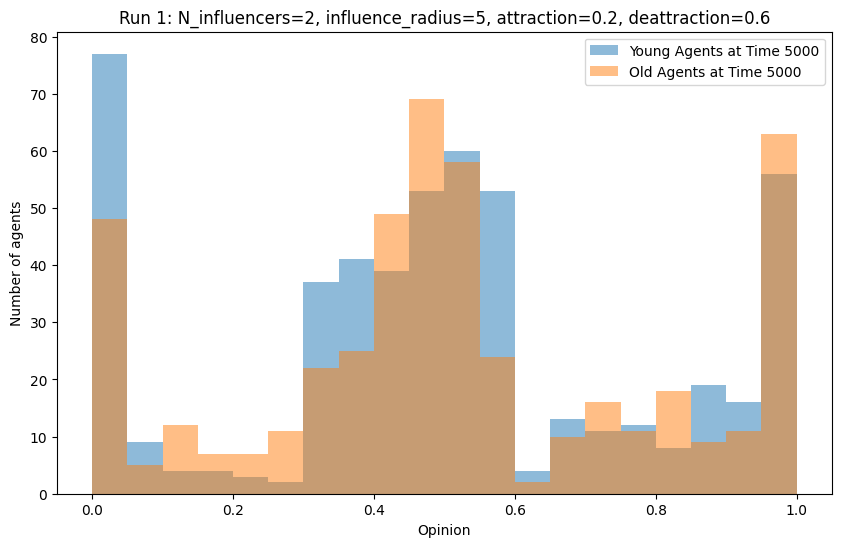

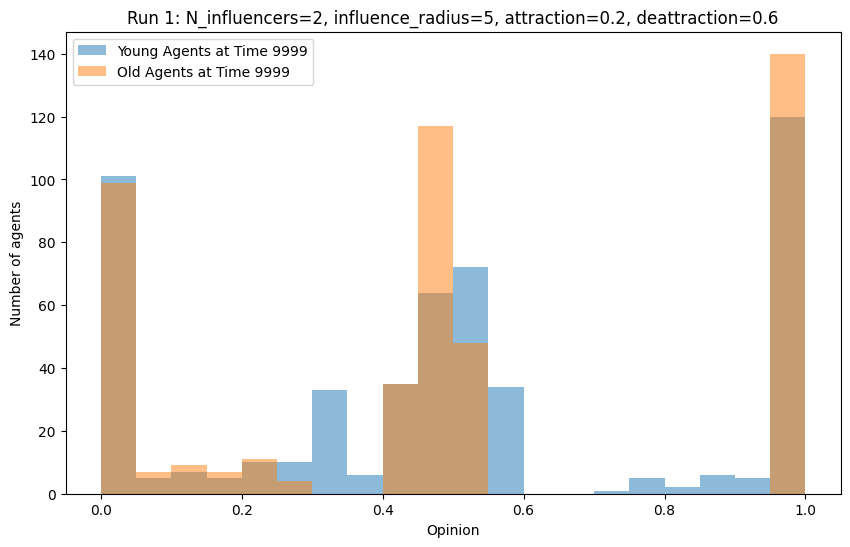

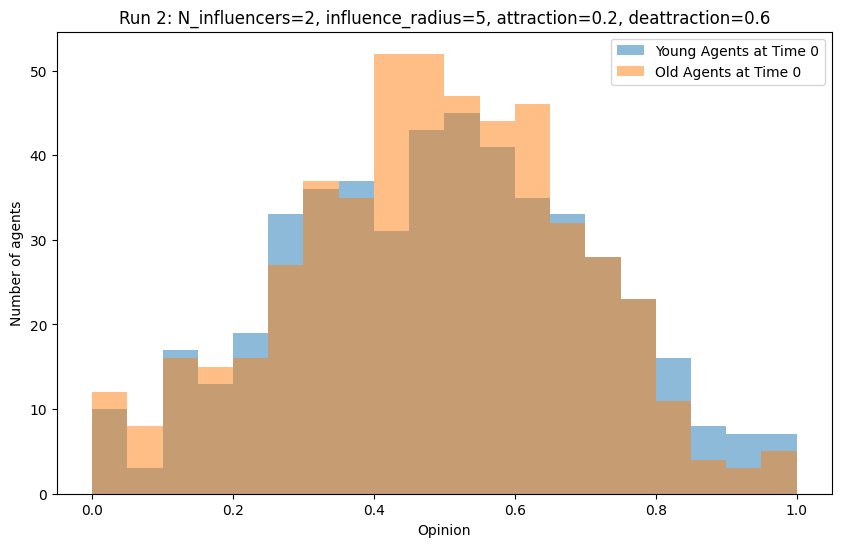

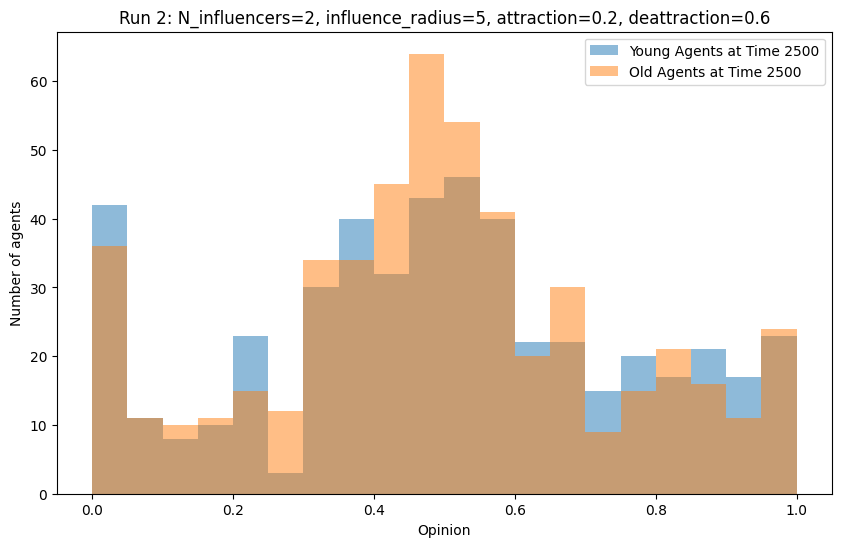

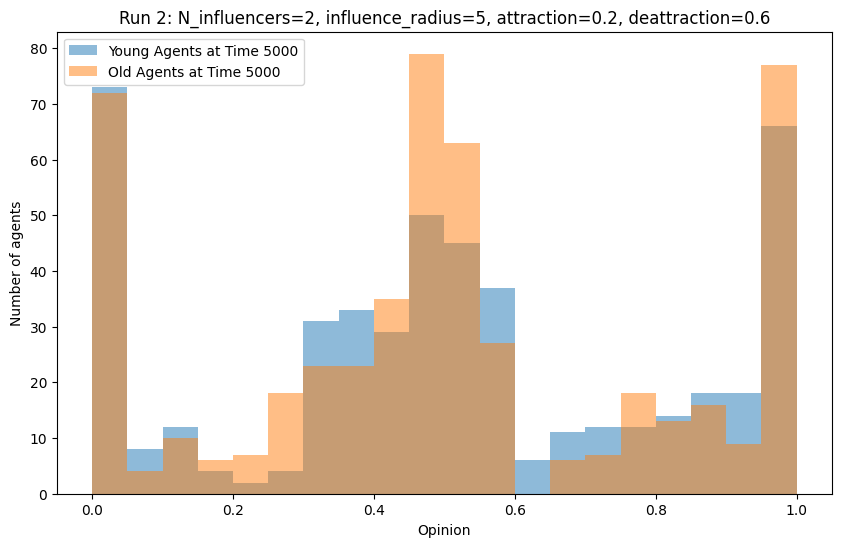

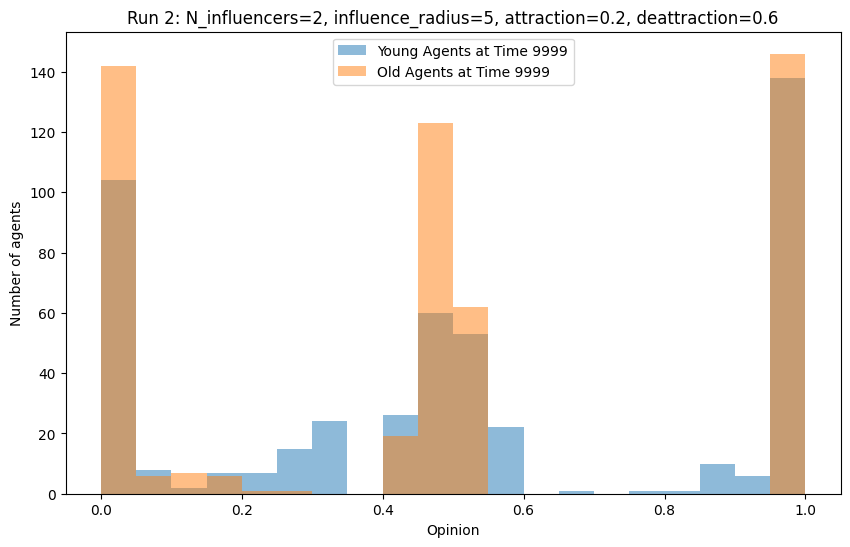

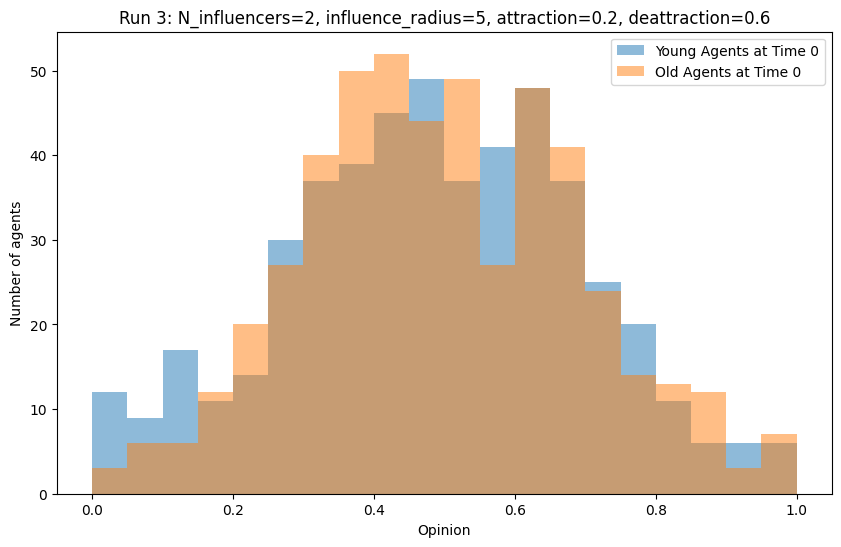

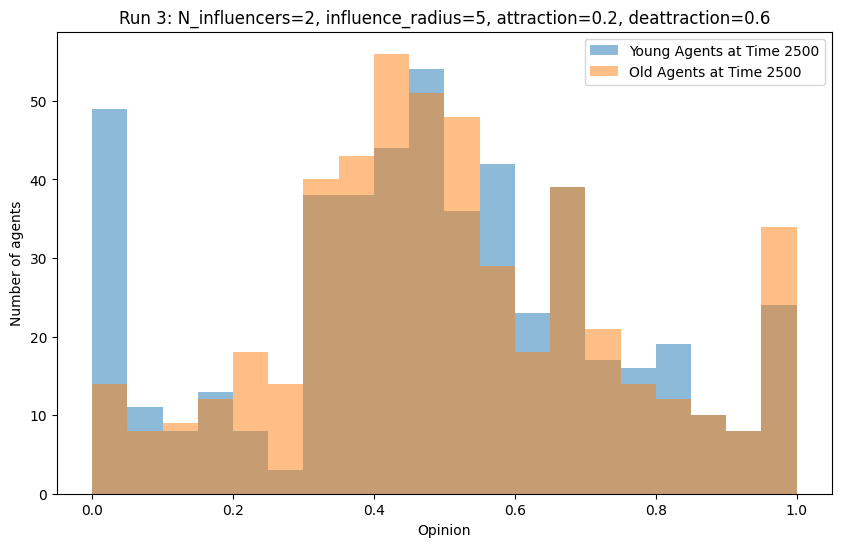

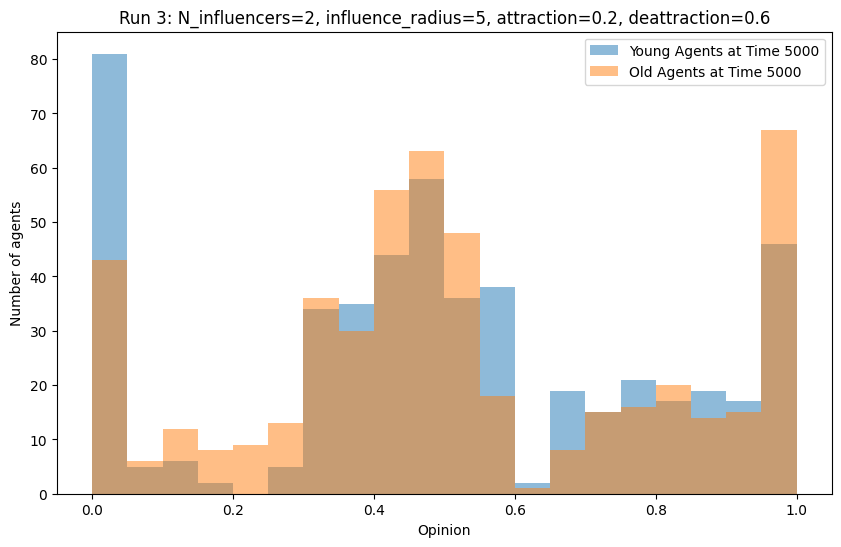

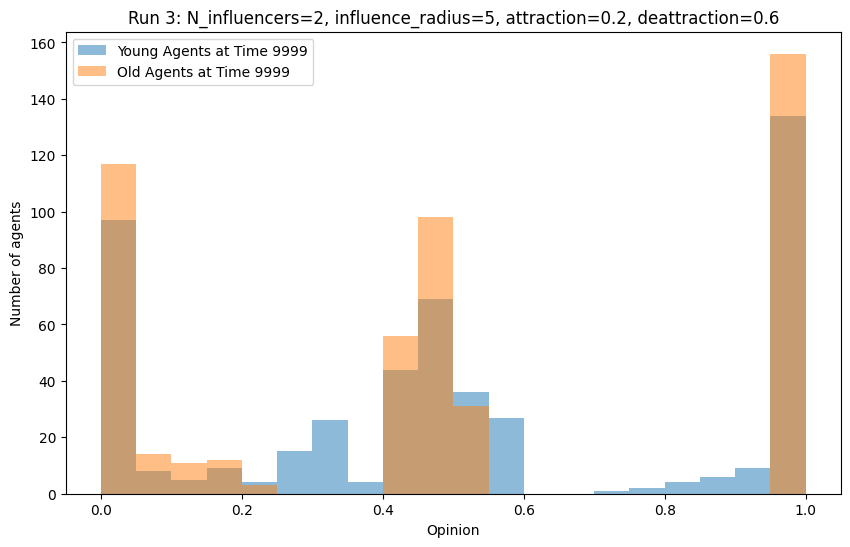

In [26]:
# Parameters
N_part = 1000        # Total number of agents (including influencers)
N_influencers = 2    # Number of influencer agents
N_media = 2          # Number of media agents
L = 50               # Side length of the lattice
d = 0.95             # Diffusion probability
mu = 0.001             # Convergence parameter
attraction = 0.2        # Confidence bound
deattraction = 0.6      # Deattraction bound
influence_radius = 5 # Influence radius for influencer agents
media_radius = 5     # Influence radius for media agents
max_steps = 10000     # Maximum number of time steps
num_runs = 3         # Number of independent runs

simulate_and_plot(
    N_part, N_influencers, N_media, L, d, mu, attraction, deattraction ,influence_radius, media_radius,max_steps, num_runs,
    title=f'N_influencers={N_influencers}, influence_radius={influence_radius}, attraction={attraction}, deattraction={deattraction}'
)